# Maintenance Requests Forecasting with Deep Learning

## Import Libraries

In [1]:
# Processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math

# Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, l1

# Metrics
from sklearn.metrics import mean_absolute_error

# Visualization
import matplotlib.pyplot as plt

## Load Data

In [2]:
dataset_raw = pd.read_csv(r'data\data_raw.csv')
dataset_processed = dataset_raw.copy()

In [3]:
dataset_raw.head()

,data_cadastro,requisicoes
0,2016-10-10,1
1,2016-10-13,3
2,2016-10-14,1
3,2016-10-17,2
4,2016-10-19,1


In [4]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data_cadastro  704 non-null    object
 1   requisicoes    704 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ KB


## Data Preparation

### Converter data_cadastro para o tipo datetime

In [5]:
dataset_processed['data_cadastro'] = pd.to_datetime(dataset_processed['data_cadastro'], format='%Y-%m-%d')
print('data_cadastro type:', dataset_processed['data_cadastro'].dtype)

data_cadastro type: datetime64[ns]


### Armazenando a data de início e fim da série temporal

In [6]:
date_start = dataset_processed['data_cadastro'].min()
date_end = dataset_processed['data_cadastro'].max()
print('Início da série temporal:', date_start)
print('Fim da série temporal:', date_end)

Início da série temporal: 2016-10-10 00:00:00
Fim da série temporal: 2023-10-25 00:00:00


### Preencher a série temporal 

In [7]:
# Crie um DataFrame com todas as datas no intervalo desejado.
datas_todas = pd.date_range(start=date_start, end=date_end, freq='D')

# Defina a coluna 'data' como o índice do DataFrame.
dataset_processed.set_index('data_cadastro', inplace=True)

# Junte (merge) os DataFrames para adicionar os registros ausentes.
# Use 'outer' para incluir todas as datas e preencher os valores ausentes com 0.
dataset_processed = datas_todas.to_frame().merge(dataset_processed, left_index=True, right_index=True, how='outer')

# Preencha os valores ausentes com 0.
dataset_processed['requisicoes'].fillna(0, inplace=True)

In [8]:
print('dataset_raw shape:', dataset_raw.shape)
print('dataset_processed shape:', dataset_processed.shape)

dataset_raw shape: (704, 2)
dataset_processed shape: (2572, 2)


In [9]:
dataset_processed  = dataset_processed.drop([0], axis=1)
dataset_processed.head()

,requisicoes
2016-10-10,1.0
2016-10-11,0.0
2016-10-12,0.0
2016-10-13,3.0
2016-10-14,1.0


### Adicionando Novas Variáveis de Entrada

In [10]:
# week day (monday = 0 | sunday = 6)
#dataset_processed['week_day'] = pd.DataFrame(dataset_processed.index, index=dataset_processed.index)[0].dt.day_name()
dataset_processed['week_day'] = pd.DataFrame(dataset_processed.index, index=dataset_processed.index)[0].dt.weekday
dataset_processed

,requisicoes,week_day
2016-10-10,1.0,0
2016-10-11,0.0,1
2016-10-12,0.0,2
2016-10-13,3.0,3
2016-10-14,1.0,4
...,...,...
2023-10-21,0.0,5
2023-10-22,0.0,6
2023-10-23,2.0,0
2023-10-24,0.0,1


In [11]:
# month
dataset_processed['month'] = pd.DataFrame(dataset_processed.index, index=dataset_processed.index)[0].dt.month
dataset_processed

,requisicoes,week_day,month
2016-10-10,1.0,0,10
2016-10-11,0.0,1,10
2016-10-12,0.0,2,10
2016-10-13,3.0,3,10
2016-10-14,1.0,4,10
...,...,...,...
2023-10-21,0.0,5,10
2023-10-22,0.0,6,10
2023-10-23,2.0,0,10
2023-10-24,0.0,1,10


In [12]:
dataset_processed = dataset_processed[['month','week_day','requisicoes']]
dataset_processed

,month,week_day,requisicoes
2016-10-10,10,0,1.0
2016-10-11,10,1,0.0
2016-10-12,10,2,0.0
2016-10-13,10,3,3.0
2016-10-14,10,4,1.0
...,...,...,...
2023-10-21,10,5,0.0
2023-10-22,10,6,0.0
2023-10-23,10,0,2.0
2023-10-24,10,1,0.0


In [13]:
dataset_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2572 entries, 2016-10-10 to 2023-10-25
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        2572 non-null   int32  
 1   week_day     2572 non-null   int32  
 2   requisicoes  2572 non-null   float64
dtypes: float64(1), int32(2)
memory usage: 60.3 KB


### Univariate Time Series Reframe for Multi-step Forecasting with LSTM Models 

#### Split into Samples

In [14]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
   
    return np.array(X), np.array(y)

In [15]:
n_features = 3
n_steps_in = 30
n_steps_out = 30
X, y = split_sequences(dataset_processed.values,n_steps_in,n_steps_out)
print('X shape:',X.shape)
print('y shape:',y.shape)

X shape: (2514, 30, 3)
y shape: (2514, 30)


In [16]:
for i in range(2):
    print(X[i], y[i])

[[10.  0.  1.]
 [10.  1.  0.]
 [10.  2.  0.]
 [10.  3.  3.]
 [10.  4.  1.]
 [10.  5.  0.]
 [10.  6.  0.]
 [10.  0.  2.]
 [10.  1.  0.]
 [10.  2.  1.]
 [10.  3.  0.]
 [10.  4.  0.]
 [10.  5.  0.]
 [10.  6.  0.]
 [10.  0.  0.]
 [10.  1.  0.]
 [10.  2.  0.]
 [10.  3.  0.]
 [10.  4.  1.]
 [10.  5.  0.]
 [10.  6.  0.]
 [10.  0.  0.]
 [11.  1.  0.]
 [11.  2.  0.]
 [11.  3.  2.]
 [11.  4.  1.]
 [11.  5.  0.]
 [11.  6.  0.]
 [11.  0.  3.]
 [11.  1.  1.]] [1. 1. 0. 0. 0. 0. 3. 0. 0. 3. 1. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 4.]
[[10.  1.  0.]
 [10.  2.  0.]
 [10.  3.  3.]
 [10.  4.  1.]
 [10.  5.  0.]
 [10.  6.  0.]
 [10.  0.  2.]
 [10.  1.  0.]
 [10.  2.  1.]
 [10.  3.  0.]
 [10.  4.  0.]
 [10.  5.  0.]
 [10.  6.  0.]
 [10.  0.  0.]
 [10.  1.  0.]
 [10.  2.  0.]
 [10.  3.  0.]
 [10.  4.  1.]
 [10.  5.  0.]
 [10.  6.  0.]
 [10.  0.  0.]
 [11.  1.  0.]
 [11.  2.  0.]
 [11.  3.  2.]
 [11.  4.  1.]
 [11.  5.  0.]
 [11.  6.  0.]
 [11.  0.  3.]
 [11.  1.  1.]
 [11.  2.  1.]] [1. 0

#### Reshape Subsequences

In [17]:
m = X.shape[0]
X_train = X[0:math.floor(m*0.6)]
y_train = y[0:math.floor(m*0.6)]

X_val = X[math.floor(m*0.6):math.floor(m*0.8)]
y_val = y[math.floor(m*0.6):math.floor(m*0.8)]

X_test = X[math.floor(m*0.8):]
y_test = y[math.floor(m*0.8):]

In [18]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print()
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print()
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1508, 30, 3)
y_train shape: (1508, 30)

X_val shape: (503, 30, 3)
y_val shape: (503, 30)

X_test shape: (503, 30, 3)
y_test shape: (503, 30)


## Modeling

### Define the model

In [19]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(n_steps_in,n_features), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
#model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(n_steps_in,n_features), kernel_regularizer=l1(0.01), recurrent_regularizer=l1(0.01)))
#model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(n_steps_in,n_features)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# model.add(LSTM(100, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(n_steps_out, activation='relu'))

### Compile the model

In [20]:
model.compile(optimizer='adam', loss='mse')

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, restore_best_weights=True, mode='min')

### fit the model

In [22]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

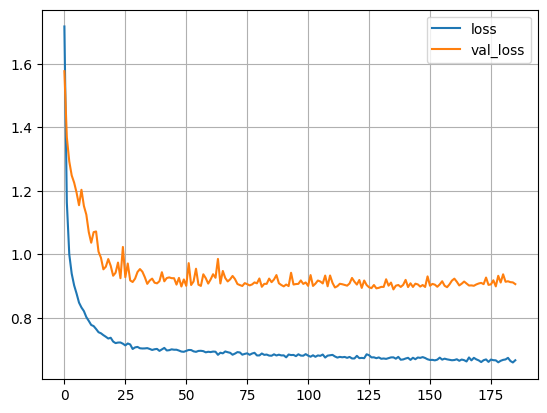

In [23]:
plt.plot(pd.DataFrame(history.history)['loss'], label='loss')
plt.plot(pd.DataFrame(history.history)['val_loss'], label='val_loss')

plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Verifique em qual época o treinamento foi interrompido
print(f"O treinamento foi interrompido na época {early_stopping.stopped_epoch}")
print(f"A melhor época foi a {early_stopping.best_epoch}")

O treinamento foi interrompido na época 185
A melhor época foi a 135


## Results

In [25]:
#y_pred = np.round(np.sum(model.predict(X_test), axis=1)).astype(int)
y_pred = np.sum(np.round(model.predict(X_test)),axis=1).astype(int)
y_test_processed = np.sum(y_test, axis=1)
print('y_pred shape:', y_pred.shape)
print('y_test shape:', y_test_processed.shape)

16/16 [==============================] - 1s 10ms/step
y_pred shape: (503,)
y_test shape: (503,)


In [26]:
print('Mean Absolute Error:', round(mean_absolute_error(y_test_processed, y_pred)))

Mean Absolute Error: 9



Amostra 1
Total de requisições reais: 27
Total de requisições previstas: [16]
Erro absoluto:[11]


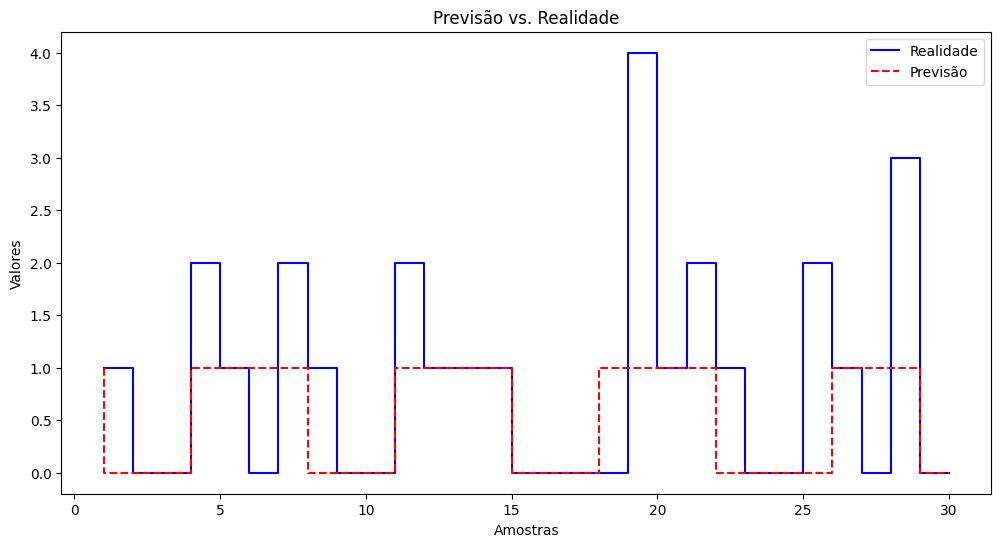


Amostra 2
Total de requisições reais: 26
Total de requisições previstas: [17]
Erro absoluto:[9]


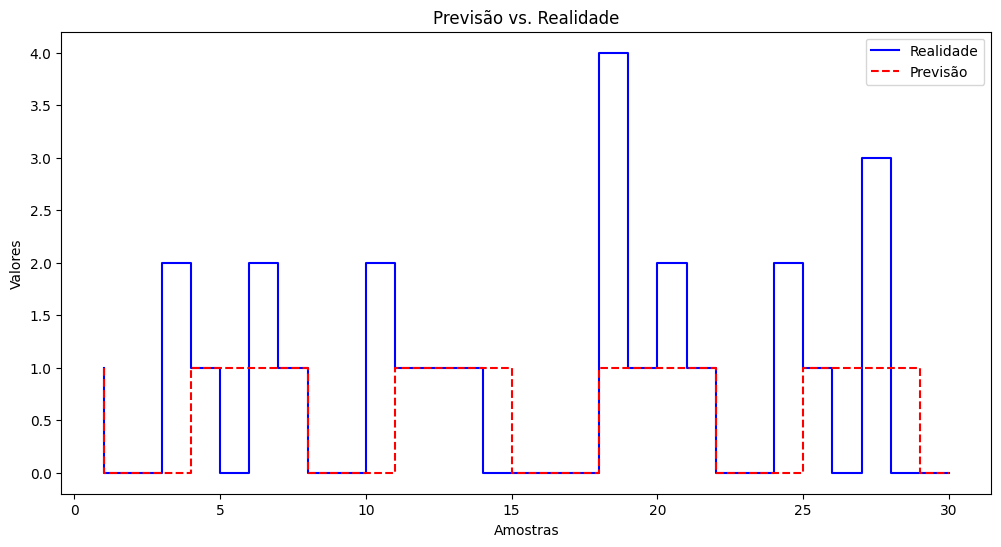


Amostra 3
Total de requisições reais: 25
Total de requisições previstas: [16]
Erro absoluto:[9]


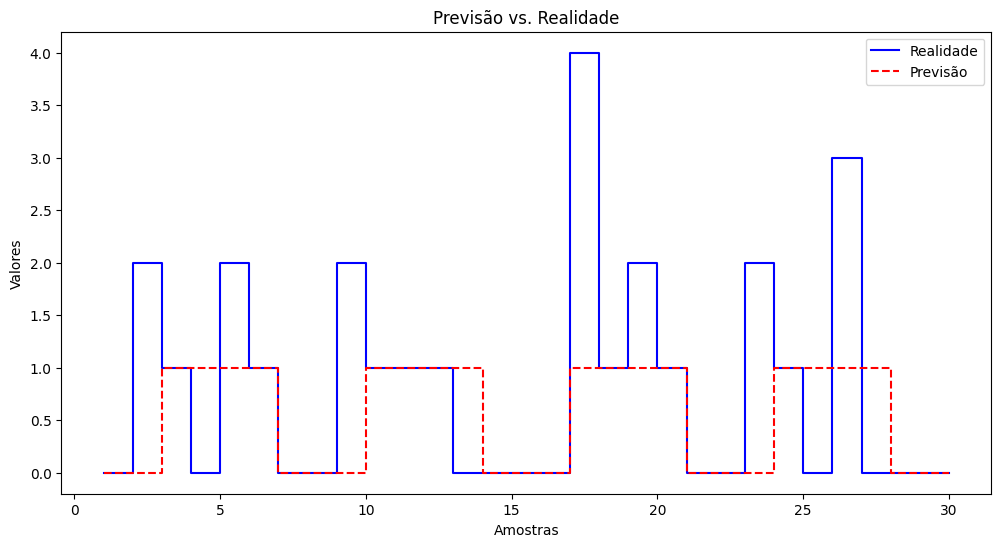


Amostra 4
Total de requisições reais: 25
Total de requisições previstas: [20]
Erro absoluto:[5]


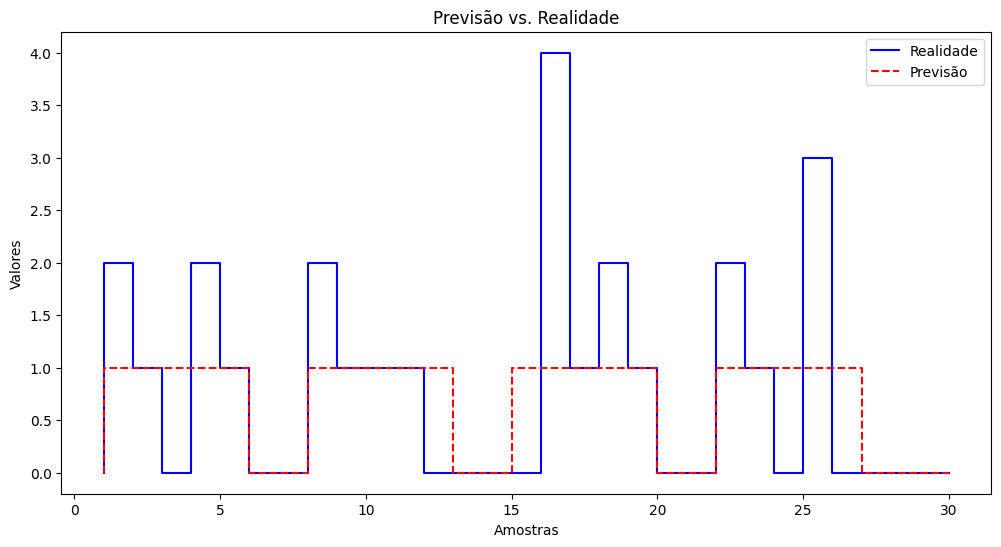


Amostra 5
Total de requisições reais: 29
Total de requisições previstas: [22]
Erro absoluto:[7]


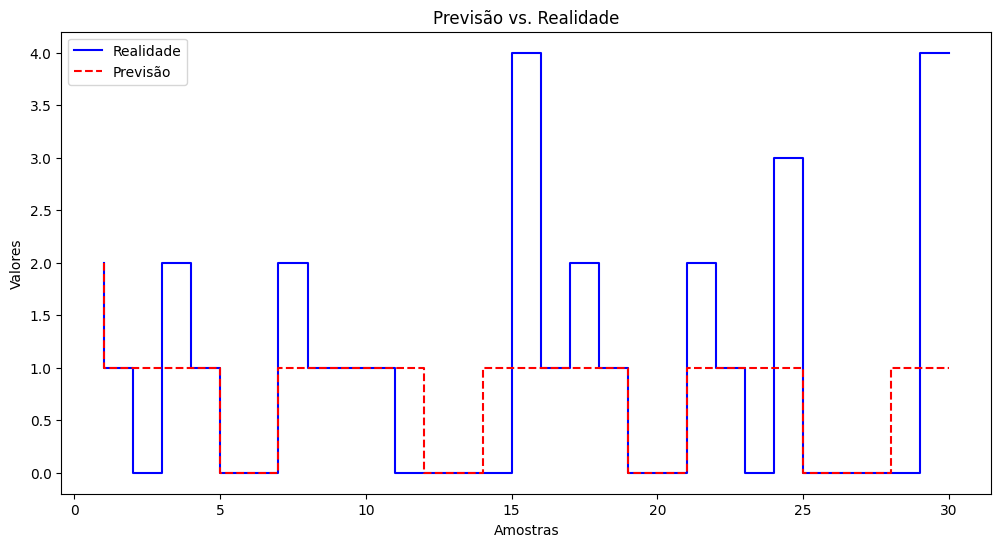


Amostra 6
Total de requisições reais: 28
Total de requisições previstas: [21]
Erro absoluto:[7]


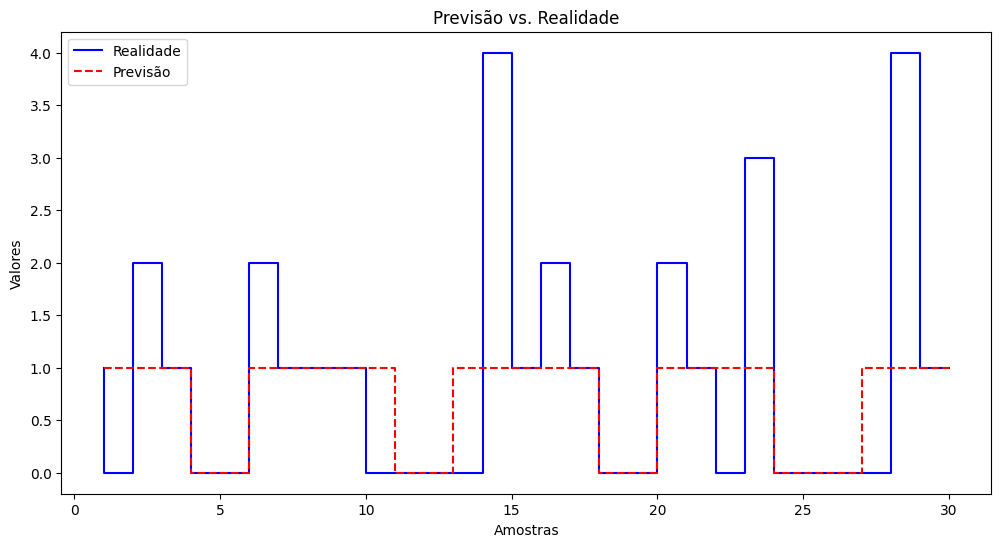


Amostra 7
Total de requisições reais: 27
Total de requisições previstas: [18]
Erro absoluto:[9]


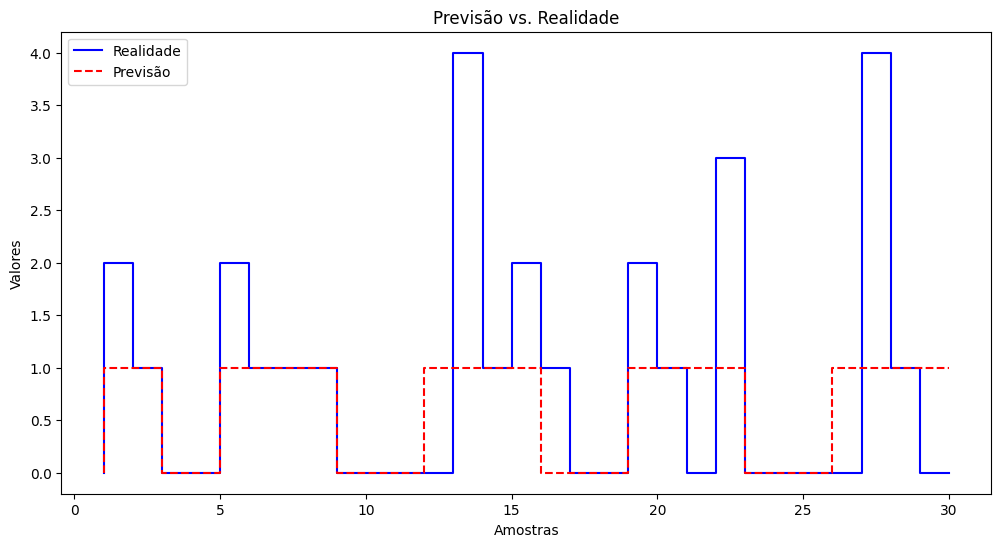


Amostra 8
Total de requisições reais: 27
Total de requisições previstas: [20]
Erro absoluto:[7]


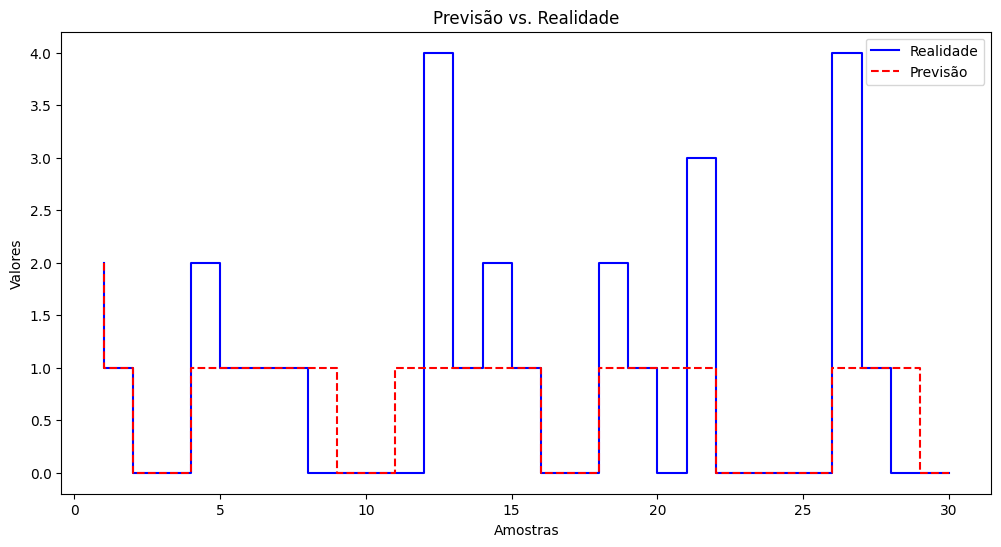


Amostra 9
Total de requisições reais: 25
Total de requisições previstas: [19]
Erro absoluto:[6]


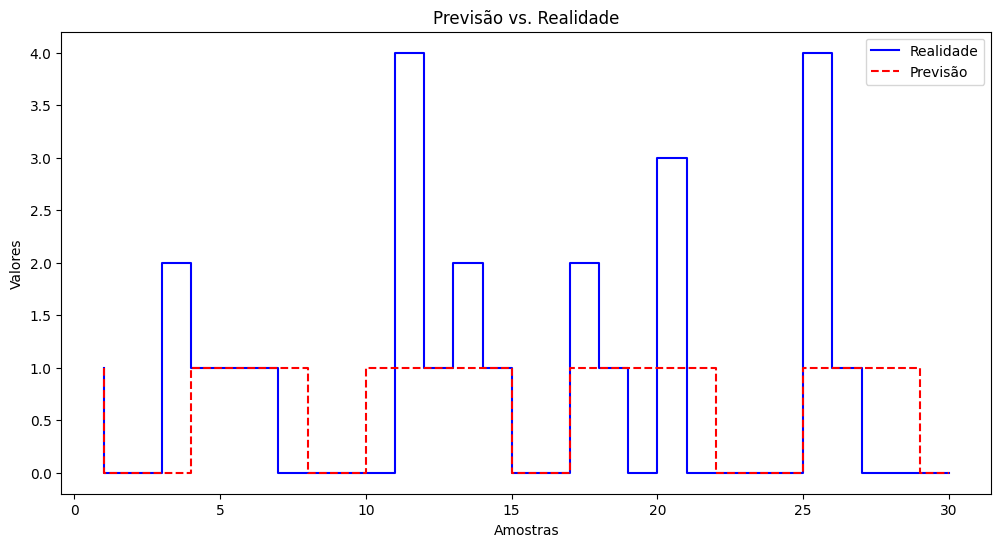


Amostra 10
Total de requisições reais: 24
Total de requisições previstas: [16]
Erro absoluto:[8]


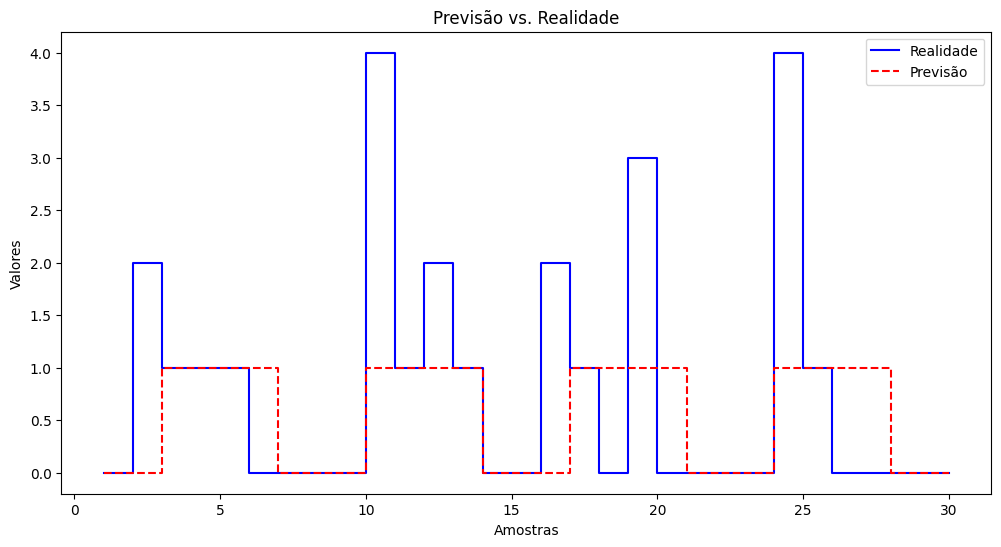

In [27]:
x = np.arange(n_steps_out)+1
for i in range(10):
    #y_pred_processed =  np.round(np.sum(model.predict(X_test[i].reshape((1, n_steps_in, n_features)), verbose=0), axis=1)).astype(int)
    y_pred_processed = np.sum(np.round(model.predict(X_test[i].reshape((1, n_steps_in, n_features)), verbose=0)),axis=1).astype(int)
    y_test_processed = int(sum(y_test[i]))
    
    print()
    print(f'Amostra {i+1}')
    print('Total de requisições reais:', y_test_processed)
    print('Total de requisições previstas:', y_pred_processed)
    print(f'Erro absoluto:{abs(y_test_processed-y_pred_processed)}')
    
    y_pred = model.predict(X_test[i].reshape((1, n_steps_in, n_features)), verbose=0);
    # Plotar os resultados
    plt.figure(figsize=(12, 6))
    plt.step(x, y_test[i].reshape(n_steps_out), label='Realidade', color='blue')
    plt.step(x, np.round(y_pred.reshape(n_steps_out)).astype(int), label='Previsão', color='red', linestyle='--')
    plt.title('Previsão vs. Realidade')
    plt.xlabel('Amostras')
    plt.ylabel('Valores')
    plt.legend()
    #plt.grid(True)
    plt.show()

## Draft

<Axes: xlabel='0'>

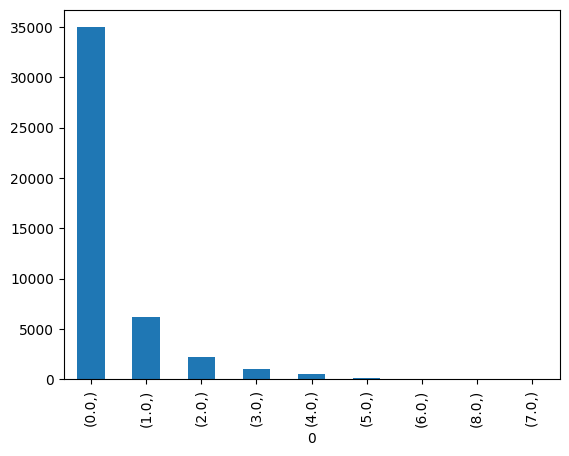

In [28]:
pd.DataFrame(y_train.reshape(1508*30,1)).value_counts().plot(kind='bar')

<Axes: xlabel='0'>

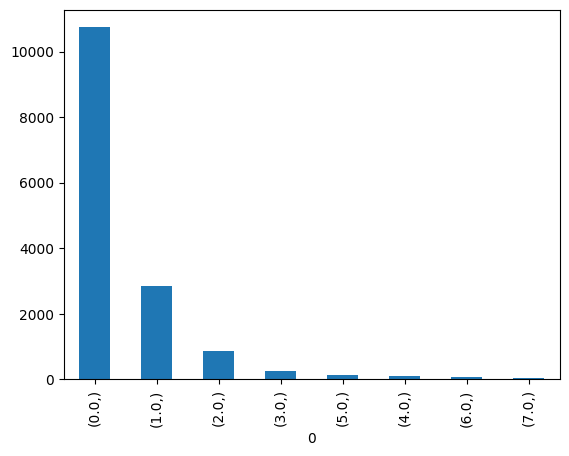

In [29]:
pd.DataFrame(y_val.reshape(503*30,1)).value_counts().plot(kind='bar')

<Axes: xlabel='0'>

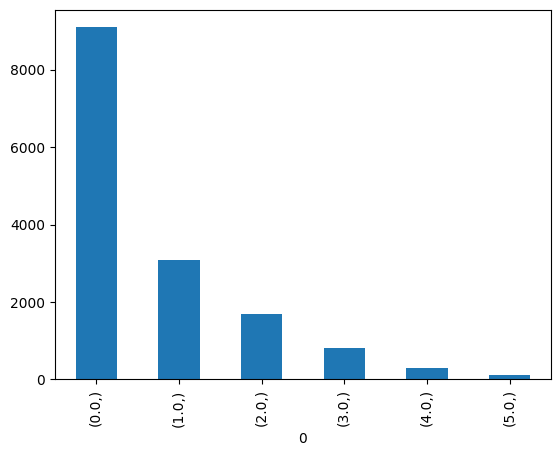

In [30]:
pd.DataFrame(y_test.reshape(503*30,1)).value_counts().plot(kind='bar')

16/16 [==============================] - 0s 12ms/step


<Axes: xlabel='0'>

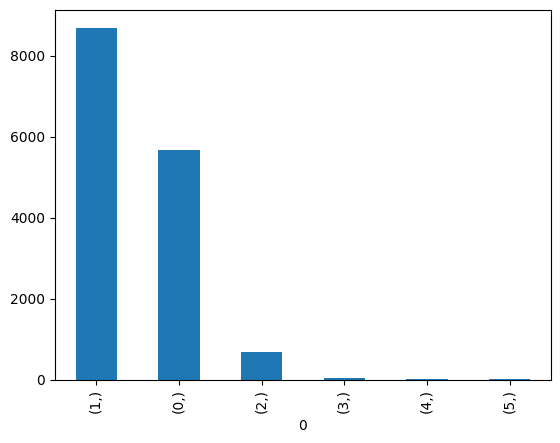

In [31]:
pd.DataFrame(np.round(model.predict(X_test)).astype(int).reshape(503*30,1)).value_counts().plot(kind='bar')